In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import qmc
from scipy.sparse.linalg import ArpackNoConvergence
from tqdm import tqdm
import random
from IPython.display import display
import time

In [2]:
df = pd.read_csv('/Volumes/GoogleDrive-116698033185964814580/My Drive/Socialz/cobol_pullrequests.csv', usecols=['login', 'name'])
# Add user (u: ) repo (r: ) indicator for each node
df['login'] = df['login'].apply(lambda x: 'u: '+x)
df['name'] = df['name'].apply(lambda x: 'r: '+x)

df

,login,name
0,u: vim-sroberge,r: vimaec/g3d
1,u: vim-sroberge,r: vimaec/g3d
2,u: vim-sroberge,r: vimaec/g3d
3,u: vim-sroberge,r: vimaec/g3d
4,u: mavimaec,r: vimaec/g3d
...,...,...
1328,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1329,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1330,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1331,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples


In [3]:
# Build the adjacency matrix for user - repo (and repo - user) interactions.
adj_matrix = pd.crosstab(df['login'], df['name']).astype(float)
idx = adj_matrix.columns.union(adj_matrix.index)
adj_matrix = adj_matrix.reindex(index = idx, columns=idx, fill_value=0.0)

adj_matrix

,r: AkinJimoh/aj-soner,r: AkinJimoh/sonar-scan,r: CPWRGIT/HDDRXM0,r: CPWRGIT/HDDRXM02,r: CPWRGIT/HDDRXM0_CWC2,r: CPWRGIT/ISPWSA0,r: CPWRGIT/ISPWSA0_CWC2,r: Compuware-Corp/TotalTest-Test-Repo,r: DhineshPalanisamy/FintechAPP,r: Dxngaa/print-dxngaa,...,u: turboKittyNinja,u: ursinn,u: velivalab,u: vim-sroberge,u: waitesid,u: whitesource-bolt-for-github[bot],u: wilbertkho,u: willdoescode,u: writ3it,u: yyyxam
r: AkinJimoh/aj-soner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: AkinJimoh/sonar-scan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: CPWRGIT/HDDRXM0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: CPWRGIT/HDDRXM02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: CPWRGIT/HDDRXM0_CWC2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u: whitesource-bolt-for-github[bot],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u: wilbertkho,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u: willdoescode,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u: writ3it,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# List user and repos
users = [x for x in adj_matrix.columns if x.startswith('u: ')]
repos = [x for x in adj_matrix.columns if x.startswith('r: ')]

print(f'Number of users: {len(users)}, number of repos: {len(repos)}')
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
print(f'Directed graph with {nx.number_of_nodes(G)} nodes, {nx.number_of_edges(G)} edges and {nx.number_weakly_connected_components(G)} components')

Number of users: 145, number of repos: 117
Directed graph with 262 nodes, 192 edges and 74 components


In [5]:
def user_user_similarity(adj_matrix, repos):

    ## Get repo - user similarity (upper-right square):
    repo_user = adj_matrix.iloc[:len(repos),len(repos):]
    repo_user = repo_user/np.linalg.norm(repo_user,axis=0,keepdims=True)
    repo_user[np.isnan(repo_user)] = 0
    repo_user = np.dot(repo_user.transpose(),repo_user)

    ## Get user - repo similarity (lower-left square):
    user_repo = adj_matrix.iloc[len(repos):,:len(repos)]
    user_repo = user_repo/np.linalg.norm(user_repo,axis=1,keepdims=True)
    user_repo[np.isnan(user_repo)] = 0
    user_repo = np.dot(user_repo, user_repo.transpose())

    # Combine upper and lower triangles, keep 0 in the diagonal.
    user_user = np.triu(repo_user,1) + np.tril(user_repo,-1)

    # return user_user
    return user_user 

adj_matrix.loc[users, users] = user_user_similarity(adj_matrix, repos)
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
print(f'Directed graph with {nx.number_of_nodes(G)} nodes, {nx.number_of_edges(G)} edges and {nx.number_weakly_connected_components(G)} components')

Directed graph with 262 nodes, 519 edges and 74 components


In [6]:
def mutate_vector(user_vect, max_value):
    # Set a random zero value to non-zero, one at a time.
    random = np.random.randint(0,len(user_vect))

    if 0 in user_vect.to_list():
        while user_vect.iloc[random] != 0:
            random = np.random.randint(0,len(user_vect))
        user_vect.iloc[random] = np.random.randint(1,max_value) # A value between 1 and max value


    # And, with 50% chance, sets a non-zero value to 0 or add random noise.
    chance = np.random.uniform(0,1)
    random = np.random.randint(0,len(user_vect))

    if not all(user_vect == 0):
        while user_vect.iloc[random] == 0:
            random = np.random.randint(0,len(user_vect))

        if chance > 0.5:
            # Add noise
            user_vect.iloc[random] = np.clip(user_vect.iloc[random] + np.random.choice([-1,1]) * np.random.randint(1,max_value),1,max_value)
        else:
            # Set to zero
            user_vect.iloc[random] = 0

    return user_vect

In [7]:
# Christoph variation, mutating single contributions, i.e., changing numbers by adding or subtracting 1 (but not have negative numbers)

# def mutate_vector(user_vect, max_value):
#     # Set a random zero value to non-zero, one at a time.
#     random = np.random.randint(0,len(user_vect))

#     user_vect.iloc[random] = np.clip(user_vect.iloc[random] + np.random.choice([-1,1]),0,max_value)

#     return user_vect

In [8]:
# Mutator, give it an adj_matrix, and it will return the mutated adj_matrix.

def mutate(adj_matrix, node, repos, users):

  # Create copies of adj_matrix and user node:
  am          = adj_matrix.copy()
  user_index  = am.loc[node][:len(repos)]
  user_column = am.loc[:,node][:len(repos)]

  # Mutate user node:
  max_value = am.max().max()
  am.loc[node][:len(repos)]   = mutate_vector(user_index, max_value)
  am.loc[:,node][:len(repos)] = mutate_vector(user_column, max_value)

  # Evaluate similarity:
  am.loc[users, users] = user_user_similarity(am, repos)
  
  return am

In [9]:
# Compute graph metrics, betweenness centrality and node degree

def graph_metrics(adj_matrix, centrality):

     G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

     # nx.eigenvector_centrality
     if centrality == nx.eigenvector_centrality:
          centrality_column = 'eigenvector_centrality'
          result = None
          i = 1000
          tol = 1.0e-6
          while result is None:
               try:
                    result = {'degree' : {node:val for (node, val) in G.degree()},
                              centrality_column: nx.eigenvector_centrality(G, max_iter=i, tol=tol)}
               except nx.exception.PowerIterationFailedConvergence:
                    i += 500
                    if i > 10000:
                         tol = 1.0e-5
               except ArpackNoConvergence:
                    i += 500
                    if i > 10000:
                         tol = 1.0e-5

     # nx.katz_centrality:
     if centrality == nx.katz_centrality:
          centrality_column = 'katz_centrality'
          result = None
          i = 1000
          tol = 1.0e-6
          while result is None:
               try:
                    result = {'degree' : {node:val for (node, val) in G.degree()} ,
                              centrality_column : centrality(G,normalized=False,max_iter=i,tol=tol)}
               except nx.exception.PowerIterationFailedConvergence:
                    i += 500
                    if i > 10000:
                         tol = 1.0e-5

     # nx.pagerank:
     if centrality == nx.pagerank:
          centrality_column = 'pagerank'
          result = {'degree' : {node:val for (node, val) in G.degree()} ,
                    centrality_column : centrality(G)}

     # nx.betweenness_centrality
     if centrality == nx.betweenness_centrality:
          centrality_column = 'betweenness_centrality'
          result = {'degree' : {node:val for (node, val) in G.degree()} ,
                    centrality_column : centrality(G,normalized=False)}

     # nx.degree_centrality
     if centrality == nx.degree_centrality:
          centrality_column = 'degree_centrality'
          s = 1.0 / (len(G) - 1.0)
          result = nx.degree_centrality(G)
          result = {k: v/s for k,v in result.items()} # undo normalisation
          result = {centrality_column:result}
          aux = {'degree' : {node:val for (node, val) in G.degree()}}
          result = aux | result # merge dicts

     # nx.closeness_centrality
     if centrality == nx.closeness_centrality:
          centrality_column = 'closeness_centrality'
          result = {'degree' : {node:val for (node, val) in G.degree()} ,
                    centrality_column:nx.closeness_centrality(G, wf_improved=False)}

     # Dict to DataFrame, normalise values
     # normalise node degree values  https://www.statology.org/normalize-data-between-0-and-1/
     # zi = (xi – min(x)) / (max(x) – min(x))
     result = pd.DataFrame(result)
     result['degree'] = result['degree'].apply(lambda x: (x - result['degree'].min())/(result['degree'].max() - result['degree'].min()))
     result[centrality_column] = result[centrality_column].apply(lambda x: (x - result[centrality_column].min())/(result[centrality_column].max() - result[centrality_column].min()))

     # filter users
     result = result[result.index.str.startswith('u: ')]

     return result

In [10]:
# Evaluate metrics in terms of star-discrepancy

def objective(candidate):
  return qmc.discrepancy(candidate, method='L2-star',workers=-1)

In [11]:
# evolution strategy (mu, lambda) algorithm

def es_plus(initial_record, objective, n_iter, mu, lam, centrality):
  best, best_eval, start = None, 1e+10, time.time()

  # number of repos and users:
  users = [x for x in adj_matrix.columns if x.startswith('u: ')]
  repos = [x for x in adj_matrix.columns if x.startswith('r: ')]

	# calculate the number of children per parent
  n_children = int(lam / mu)
	
  # initial population
  population = list()
  
  for i in range(lam):
    candidate = initial_record.copy()       # copy the initial matrix
    population.append(candidate)            # add to population

  # perform the search
  for epoch in range(n_iter):
    # evaluate the fitness for the population
    scores = [objective(graph_metrics(candidate,centrality)) for candidate in population]
    # rank scores in ascending order
    ranks = np.argsort(np.argsort(scores))
    # select the indexes for the top mu ranked solutions, drop the worse results	
    selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
    # create offspring from parents
    offspring = list()
    for i in selected:
      # check if this parent is the best solution ever seen
      if scores[i] < best_eval:
        best, best_eval, niter = population[i], scores[i], epoch
        #print('%d, Best eval: = %.5f' % (epoch, best_eval))
        
        # keep the parent
        offspring.append(population[i])

        # create offspring for parent
        for j in range(n_children):

          sample = np.random.choice(users)
          child = mutate(population[i], sample, repos, users)
          offspring.append(child)

    # replace population with children
    population = offspring

  end = time.time()
  total_time = end - start
  return [niter, best, best_eval, total_time]

In [12]:
def plot_results(ax, user_node, bot_node, adj_matrix, metric):

    ax = ax or plt.gca()

    metric_df = graph_metrics(adj_matrix, metric)

    ax.scatter(metric_df.iloc[:,0],metric_df.iloc[:,1],edgecolor="k", c="r")
    ax.set_xlabel('Degree')
    ax.set_ylabel(str(metric).split(' ')[1])
    ax.annotate('mike', (metric_df.loc[user_node][0], metric_df.loc[user_node][1]))
    ax.annotate('bot', (metric_df.loc[bot_node][0] - 0.05, metric_df.loc[bot_node][1]- 0.05))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.text(0.5,-0.5,f'Star-discrepancy score: {objective(metric_df):.3f}',fontsize='large',horizontalalignment='center')
    plt.close()
    
    return ax

In [13]:
def plot_all_results(initial_matrix, best_matrix, centrality, G, N, lam, mu, n_iter, seeds, pos):

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
    ax1.set_title('Initial evaluation:',fontsize='x-large')
    ax2.set_title('Best evolved results:',fontsize='x-large')
    plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', initial_matrix, centrality)
    plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best_matrix, centrality)
    color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
    nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
    nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
    ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
    ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
    fig.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
    fig.tight_layout()
    plt.close()
    
    return fig

In [14]:
def find_seed(n_seeds, adj_matrix, objective, n_iter, mu, lam, centrality, connected):

    scores =   {'seed':[],
                'best_iter':[],
                'score':[],
                'nodes':[],
                'edges':[],
                'components':[],
                'mu':[],
                'lam':[],
                'total_iter':[],
                'centrality':[],
                'time':[],
                'connected':[]}

    for i in tqdm(range(n_seeds)):
        
        # set a seed
        np.random.seed(i)
        # define the total iterations
        n_iter = n_iter
        # number of parents selected
        mu = mu
        # the number of children generated by parents
        lam = lam
        # perform the evolution strategy (mu, lambda) search
        iterations, best, score, ttime = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)
        # compute the resulting graph
        N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)
        # get the number of nodes, edges and connected components
        nodes, edges, components = nx.number_of_nodes(N), nx.number_of_edges(N), nx.number_weakly_connected_components(N)

        scores['best_iter'].append(iterations)
        scores['seed'].append(i)
        scores['score'].append(score)
        scores['nodes'].append(nodes)
        scores['edges'].append(edges)
        scores['components'].append(components)
        scores['mu'].append(mu)
        scores['lam'].append(lam)
        scores['total_iter'].append(n_iter)
        scores['centrality'].append(str(centrality).split(' ')[1])
        scores['time'].append(ttime)
        scores['connected'].append(connected)

    return pd.DataFrame(scores)

## Experimental results:
### (1 + 1)-EA, New mutation strategy

1.1 (1 + 1) betweenness centrality evaluation:

In [15]:
seeds, n_iter, mu, lam, centrality = 1000, 10000, 1, 1, nx.betweenness_centrality

scores = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality, False)
scores.sort_values('score')

100%|██████████| 1000/1000 [04:39<00:00,  3.57it/s]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
473,473,14,0.609852,262,555,60,1,1,10000,betweenness_centrality,0.988480,False
249,249,12,0.610138,262,550,57,1,1,10000,betweenness_centrality,0.840325,False
847,847,14,0.611245,262,567,57,1,1,10000,betweenness_centrality,0.954661,False
263,263,5,0.614238,262,529,69,1,1,10000,betweenness_centrality,0.415394,False
173,173,5,0.614258,262,529,69,1,1,10000,betweenness_centrality,0.482842,False
...,...,...,...,...,...,...,...,...,...,...,...,...
609,609,0,0.649914,262,519,74,1,1,10000,betweenness_centrality,0.112340,False
600,600,0,0.649914,262,519,74,1,1,10000,betweenness_centrality,0.113429,False
198,198,0,0.649914,262,519,74,1,1,10000,betweenness_centrality,0.117211,False
625,625,0,0.649914,262,519,74,1,1,10000,betweenness_centrality,0.111769,False


473    473
Name: seed, dtype: int64


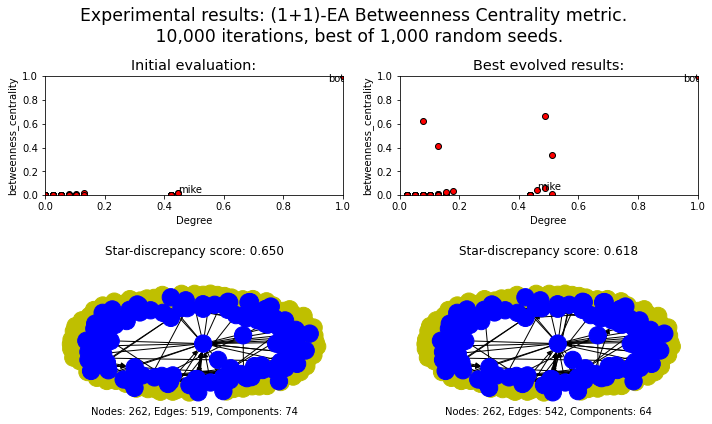

In [16]:
# set the best seed
seed = scores[scores['score'] == scores['score'].min()]['seed']
print(seed)
np.random.seed(seed)

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# Set nodes position
pos = nx.spring_layout(G)

# plot results
fig1 = plot_all_results(adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig1

1.2 (1 + 1) closeness evaluation:

In [17]:
seeds, n_iter, mu, lam, centrality = 1000, 10000, 1, 1, nx.closeness_centrality

scores_aux = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality, False)
scores = pd.concat([scores, scores_aux],axis=0)
scores[scores['centrality'] == str(centrality).split(' ')[1]].sort_values('score')

100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
594,594,8,0.288537,262,556,64,1,1,10000,closeness_centrality,0.567221,False
0,0,7,0.290028,262,533,67,1,1,10000,closeness_centrality,0.464100,False
307,307,9,0.291819,262,541,63,1,1,10000,closeness_centrality,0.554224,False
379,379,6,0.292365,262,534,66,1,1,10000,closeness_centrality,0.400440,False
162,162,8,0.293672,262,534,68,1,1,10000,closeness_centrality,0.512033,False
...,...,...,...,...,...,...,...,...,...,...,...,...
486,486,0,0.337715,262,519,74,1,1,10000,closeness_centrality,0.100723,False
485,485,0,0.337715,262,519,74,1,1,10000,closeness_centrality,0.109082,False
484,484,0,0.337715,262,519,74,1,1,10000,closeness_centrality,0.100026,False
509,509,0,0.337715,262,519,74,1,1,10000,closeness_centrality,0.102044,False


594    594
Name: seed, dtype: int64


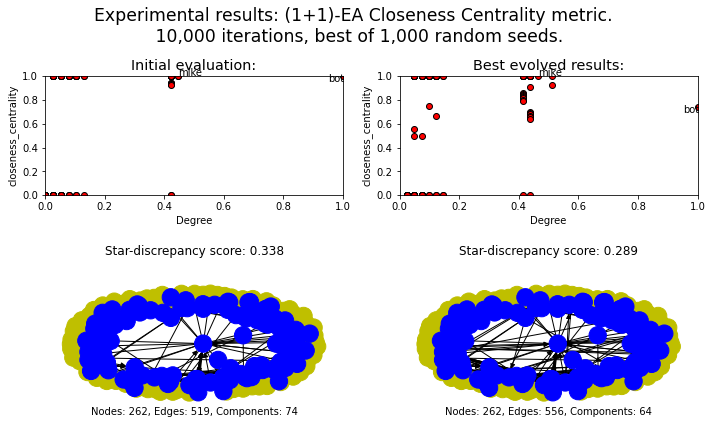

In [18]:
# set the best seed
scores_aux = scores[scores['centrality'] == str(centrality).split(' ')[1]]
seed = scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed']
print(seed)
np.random.seed(seed)

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
# plot results
fig2 = plot_all_results(adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig2

1.3 (1 + 1) eignevector centrality evaluation:

In [19]:
seeds, n_iter, mu, lam, centrality = 1000, 10000, 1, 1, nx.eigenvector_centrality

scores_aux = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality, False)
scores = pd.concat([scores, scores_aux],axis=0)
scores[scores['centrality'] == str(centrality).split(' ')[1]].sort_values('score')

100%|██████████| 1000/1000 [11:58<00:00,  1.39it/s]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
357,357,9,0.613635,262,540,64,1,1,10000,eigenvector_centrality,1.576081,False
336,336,10,0.614274,262,538,62,1,1,10000,eigenvector_centrality,1.124873,False
209,209,7,0.615102,262,532,68,1,1,10000,eigenvector_centrality,0.934445,False
592,592,13,0.616060,262,597,59,1,1,10000,eigenvector_centrality,2.872351,False
528,528,14,0.617448,262,548,62,1,1,10000,eigenvector_centrality,1.502090,False
...,...,...,...,...,...,...,...,...,...,...,...,...
498,498,0,0.649973,262,519,74,1,1,10000,eigenvector_centrality,0.281706,False
781,781,0,0.649973,262,519,74,1,1,10000,eigenvector_centrality,0.285598,False
39,39,0,0.649973,262,519,74,1,1,10000,eigenvector_centrality,0.298769,False
789,789,0,0.649973,262,519,74,1,1,10000,eigenvector_centrality,0.284288,False


357    357
Name: seed, dtype: int64


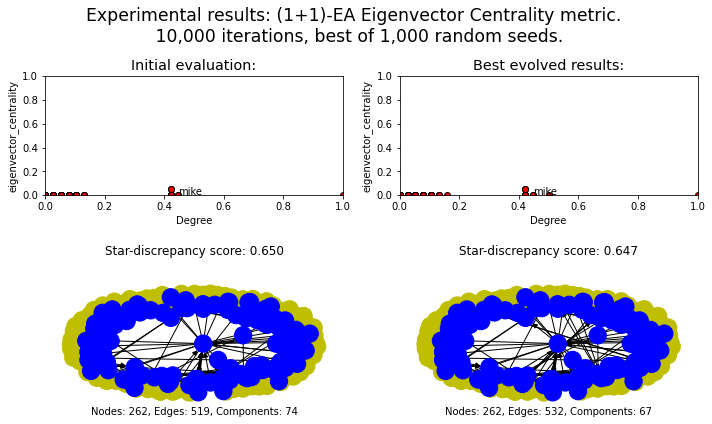

In [20]:
# set the best seed
scores_aux = scores[scores['centrality'] == str(centrality).split(' ')[1]]
seed = scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed']
print(seed)
np.random.seed(seed)

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig3 = plot_all_results(adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig3

1.4 (1 + 1) katz centrality evaluation:

In [21]:
seeds, n_iter, mu, lam, centrality = 1000, 10000, 1, 1, nx.katz_centrality

scores_aux = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality, False)
scores = pd.concat([scores, scores_aux],axis=0)
scores[scores['centrality'] == str(centrality).split(' ')[1]].sort_values('score')

100%|██████████| 1000/1000 [04:08<00:00,  4.03it/s]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
377,377,25,0.551473,262,608,48,1,1,10000,katz_centrality,1.558806,False
461,461,9,0.563755,262,544,62,1,1,10000,katz_centrality,0.593215,False
281,281,10,0.564357,262,545,64,1,1,10000,katz_centrality,0.643846,False
741,741,12,0.564390,262,547,63,1,1,10000,katz_centrality,0.760477,False
0,0,14,0.564691,262,548,59,1,1,10000,katz_centrality,0.975722,False
...,...,...,...,...,...,...,...,...,...,...,...,...
816,816,0,0.588324,262,519,74,1,1,10000,katz_centrality,0.106275,False
386,386,0,0.588324,262,519,74,1,1,10000,katz_centrality,0.105543,False
157,157,0,0.588324,262,519,74,1,1,10000,katz_centrality,0.110605,False
390,390,0,0.588324,262,519,74,1,1,10000,katz_centrality,0.106018,False


377    377
Name: seed, dtype: int64


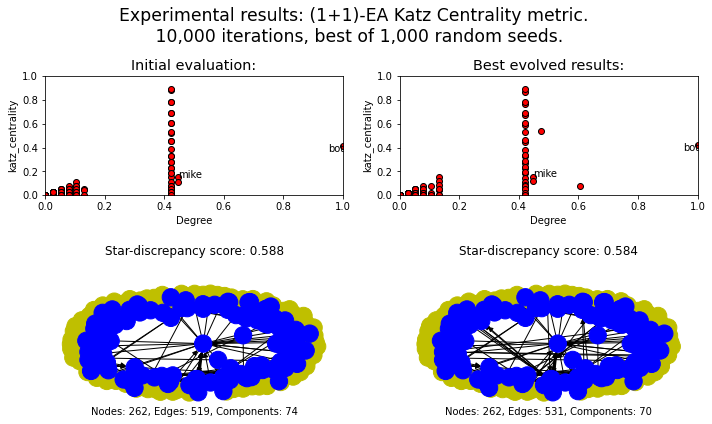

In [22]:
# set the best seed
scores_aux = scores[scores['centrality'] == str(centrality).split(' ')[1]]
seed = scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed']
print(seed)
np.random.seed(seed)

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig4 = plot_all_results(adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig4

1.5 (1 + 1) pagerank evaluation:

In [23]:
seeds, n_iter, mu, lam, centrality = 1000, 10000, 1, 1, nx.pagerank

scores_aux = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality, False)
scores = pd.concat([scores, scores_aux],axis=0)
scores[scores['centrality'] == str(centrality).split(' ')[1]].sort_values('score')

100%|██████████| 1000/1000 [03:35<00:00,  4.64it/s]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
43,43,15,0.598430,262,572,55,1,1,10000,pagerank,0.806738,False
249,249,12,0.600345,262,550,57,1,1,10000,pagerank,0.663357,False
608,608,12,0.601609,262,545,63,1,1,10000,pagerank,0.664829,False
336,336,12,0.602687,262,542,60,1,1,10000,pagerank,0.664181,False
575,575,12,0.602998,262,547,60,1,1,10000,pagerank,0.692051,False
...,...,...,...,...,...,...,...,...,...,...,...,...
62,62,0,0.632000,262,519,74,1,1,10000,pagerank,0.096077,False
63,63,0,0.632000,262,519,74,1,1,10000,pagerank,0.095128,False
750,750,0,0.632000,262,519,74,1,1,10000,pagerank,0.100843,False
748,748,0,0.632000,262,519,74,1,1,10000,pagerank,0.097115,False


43    43
Name: seed, dtype: int64


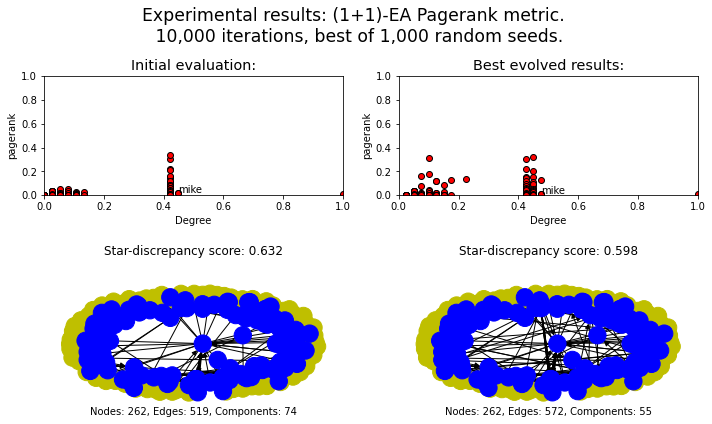

In [24]:
# set the best seed
scores_aux = scores[scores['centrality'] == str(centrality).split(' ')[1]]
seed = scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed']
print(seed)
np.random.seed(seed)

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig5 = plot_all_results(adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig5

In [25]:
with PdfPages('Single.pdf') as pdf:
    pdf.savefig(fig1)
    pdf.savefig(fig2)
    pdf.savefig(fig3)
    pdf.savefig(fig4)
    pdf.savefig(fig5)

## Experimental results:
### G = Connected graph
Add edges between connected components until end up with one weakly connected graph, i.e. a graph where all its nodes are connected in at least one direction.

In [26]:
random.seed(52)

G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
connected_components = list(nx.weakly_connected_components(G))

users_connected_components = list()
repos_connected_components = list()

for component in connected_components:

    users_aux = list()
    repos_aux = list()

    for node in component:
        if node.startswith('u: '):
            users_aux.append(node)
        else:
            repos_aux.append(node)

    users_connected_components.append(users_aux)
    repos_connected_components.append(repos_aux)

# Send first component to the last place:
repos_connected_components.append(repos_connected_components.pop(0))

for users, repos in zip(users_connected_components,repos_connected_components):
    user = random.choice(users)
    repo = random.choice(repos)
    G.add_edge(user, repo)
    G.add_edge(repo, user)

print(f'Is weakly connected\t\t\t = {nx.is_weakly_connected(G)}, \nNumber of weakly connected components\t = {nx.number_weakly_connected_components(G)}')

Is weakly connected			 = True, 
Number of weakly connected components	 = 1


In [27]:
connencted_adj_matrix = nx.to_pandas_adjacency(G)

2.1 (1 + 1) betweeness centrality evaluation:

In [28]:
seeds, n_iter, mu, lam, centrality = 1000, 10000, 1, 1, nx.betweenness_centrality

scores_aux = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality, True)
scores = pd.concat([scores, scores_aux],axis=0)
scores[(scores['centrality'] == str(centrality).split(' ')[1])&(scores['connected']==True)].sort_values('score')

100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
941,941,3,0.284695,262,790,1,1,1,10000,betweenness_centrality,0.594224,True
686,686,2,0.284811,262,790,1,1,1,10000,betweenness_centrality,0.510101,True
398,398,1,0.294174,262,788,1,1,1,10000,betweenness_centrality,0.311527,True
50,50,1,0.298116,262,791,1,1,1,10000,betweenness_centrality,0.350191,True
438,438,3,0.299784,262,792,1,1,1,10000,betweenness_centrality,0.641972,True
...,...,...,...,...,...,...,...,...,...,...,...,...
850,850,0,0.380680,262,667,1,1,1,10000,betweenness_centrality,0.173240,True
892,892,0,0.380680,262,667,1,1,1,10000,betweenness_centrality,0.184503,True
651,651,0,0.380680,262,667,1,1,1,10000,betweenness_centrality,0.167367,True
659,659,0,0.380680,262,667,1,1,1,10000,betweenness_centrality,0.170866,True


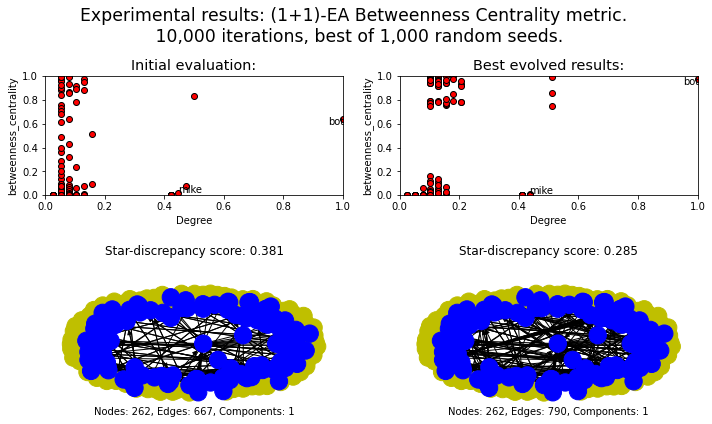

In [29]:
# set the best seed
scores_aux = scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True)]
np.random.seed(scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig1 = plot_all_results(connencted_adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig1

2.2 (1 + 1) closeness centrality evaluation:

In [30]:
seeds, n_iter, mu, lam, centrality = 1000, 10000, 1, 1, nx.closeness_centrality

scores_aux = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality, True)
scores = pd.concat([scores, scores_aux],axis=0)
scores[(scores['centrality'] == str(centrality).split(' ')[1])&(scores['connected']==True)].sort_values('score')

100%|██████████| 1000/1000 [04:20<00:00,  3.83it/s]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
248,248,6,0.405712,262,802,1,1,1,10000,closeness_centrality,0.608943,True
652,652,5,0.406372,262,788,1,1,1,10000,closeness_centrality,0.490681,True
993,993,5,0.418964,262,791,1,1,1,10000,closeness_centrality,0.438015,True
393,393,4,0.419348,262,792,1,1,1,10000,closeness_centrality,0.421701,True
463,463,6,0.420485,262,788,1,1,1,10000,closeness_centrality,0.567216,True
...,...,...,...,...,...,...,...,...,...,...,...,...
81,81,0,0.485539,262,667,1,1,1,10000,closeness_centrality,0.133869,True
412,412,0,0.485539,262,667,1,1,1,10000,closeness_centrality,0.200884,True
425,425,0,0.485539,262,667,1,1,1,10000,closeness_centrality,0.132894,True
282,282,0,0.485539,262,667,1,1,1,10000,closeness_centrality,0.134217,True


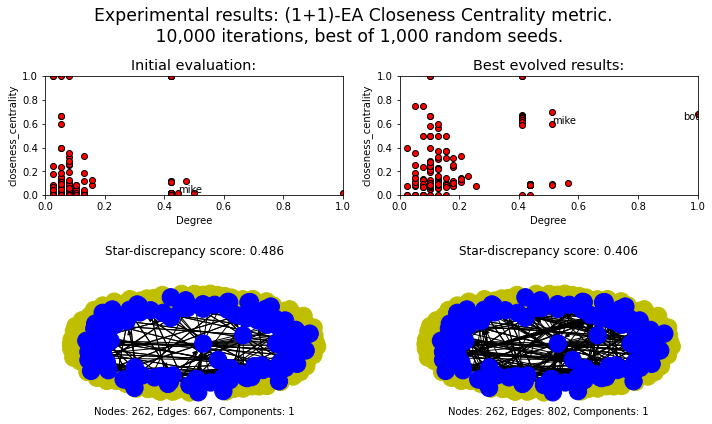

In [31]:
# set the best seed
scores_aux = scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True)]
np.random.seed(scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig2 = plot_all_results(connencted_adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig2

2.3 (1 + 1) eigenvector centrality evaluation:

In [32]:
seeds, n_iter, mu, lam, centrality = 1000, 10000, 1, 1, nx.eigenvector_centrality

scores_aux = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality, True)
scores = pd.concat([scores, scores_aux],axis=0)
scores[(scores['centrality'] == str(centrality).split(' ')[1])&(scores['connected']==True)].sort_values('score')

100%|██████████| 1000/1000 [35:04<00:00,  2.10s/it]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
898,898,16,0.489943,262,820,1,1,1,10000,eigenvector_centrality,3.169106,True
674,674,8,0.521420,262,808,1,1,1,10000,eigenvector_centrality,2.832159,True
240,240,3,0.536023,262,790,1,1,1,10000,eigenvector_centrality,2.247795,True
134,134,8,0.540267,262,794,1,1,1,10000,eigenvector_centrality,2.777172,True
293,293,4,0.540562,262,763,1,1,1,10000,eigenvector_centrality,2.594372,True
...,...,...,...,...,...,...,...,...,...,...,...,...
360,360,2,0.596501,262,770,1,1,1,10000,eigenvector_centrality,1.906646,True
239,239,2,0.597182,262,789,1,1,1,10000,eigenvector_centrality,2.047284,True
182,182,10,0.597866,262,819,1,1,1,10000,eigenvector_centrality,2.460799,True
503,503,4,0.599832,262,804,1,1,1,10000,eigenvector_centrality,2.034059,True


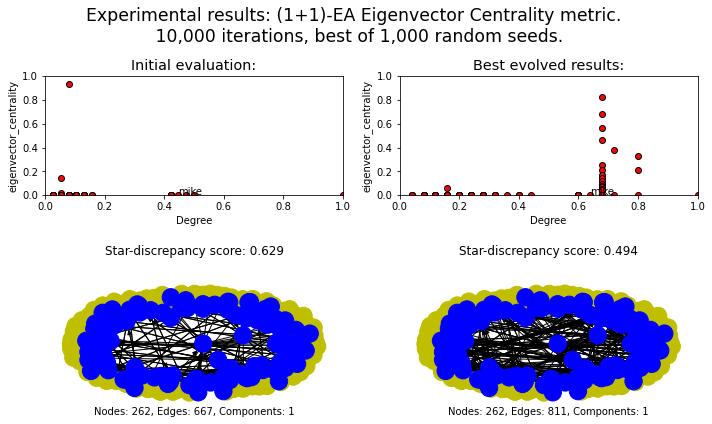

In [33]:
# set the best seed
scores_aux = scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True)]
np.random.seed(scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig3 = plot_all_results(connencted_adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig3

2.4 (1 + 1) katz centrality evaluation:


In [34]:
seeds, n_iter, mu, lam, centrality = 1000, 10000, 1, 1, nx.katz_centrality

scores_aux = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality, True)
scores = pd.concat([scores, scores_aux],axis=0)
scores[(scores['centrality'] == str(centrality).split(' ')[1])&(scores['connected']==True)].sort_values('score')

100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
539,539,29,0.474716,262,889,2,1,1,10000,katz_centrality,2.249926,True
724,724,22,0.488017,262,854,2,1,1,10000,katz_centrality,1.660856,True
216,216,20,0.492119,262,843,1,1,1,10000,katz_centrality,1.441724,True
195,195,24,0.494975,262,841,1,1,1,10000,katz_centrality,1.715244,True
871,871,13,0.497698,262,822,2,1,1,10000,katz_centrality,0.993438,True
...,...,...,...,...,...,...,...,...,...,...,...,...
26,26,3,0.533146,262,773,1,1,1,10000,katz_centrality,0.308148,True
833,833,1,0.533612,262,771,1,1,1,10000,katz_centrality,0.256796,True
239,239,2,0.535057,262,789,1,1,1,10000,katz_centrality,0.245387,True
843,843,1,0.535444,262,787,1,1,1,10000,katz_centrality,0.189246,True


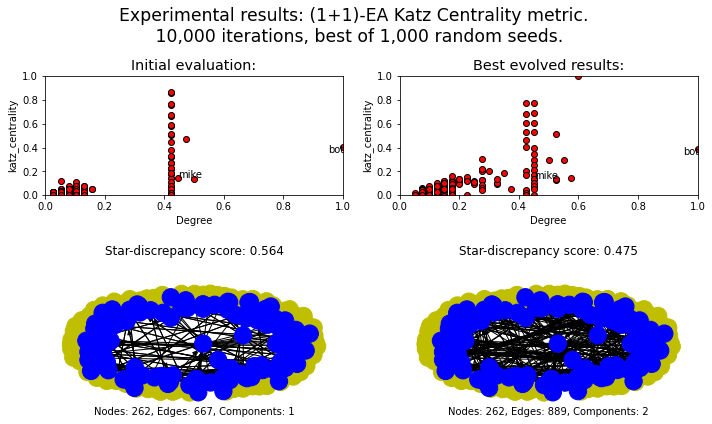

In [35]:
# set the best seed
scores_aux = scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True)]
np.random.seed(scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig4 = plot_all_results(connencted_adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig4

2.5 (1 + 1) pagerank evaluation:

In [36]:
seeds, n_iter, mu, lam, centrality = 1000, 10000, 1, 1, nx.pagerank

scores_aux = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality, True)
scores = pd.concat([scores, scores_aux],axis=0)
scores[(scores['centrality'] == str(centrality).split(' ')[1])&(scores['connected']==True)].sort_values('score')

100%|██████████| 1000/1000 [02:03<00:00,  8.11it/s]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
370,370,1,0.401609,262,787,1,1,1,10000,pagerank,0.149108,True
293,293,4,0.405059,262,763,1,1,1,10000,pagerank,0.309955,True
740,740,3,0.408076,262,789,1,1,1,10000,pagerank,0.243491,True
986,986,2,0.411283,262,790,1,1,1,10000,pagerank,0.194071,True
866,866,4,0.426010,262,792,1,1,1,10000,pagerank,0.451203,True
...,...,...,...,...,...,...,...,...,...,...,...,...
873,873,0,0.480038,262,667,1,1,1,10000,pagerank,0.099194,True
639,639,0,0.480038,262,667,1,1,1,10000,pagerank,0.099355,True
554,554,0,0.480038,262,667,1,1,1,10000,pagerank,0.096990,True
130,130,0,0.480038,262,667,1,1,1,10000,pagerank,0.118869,True


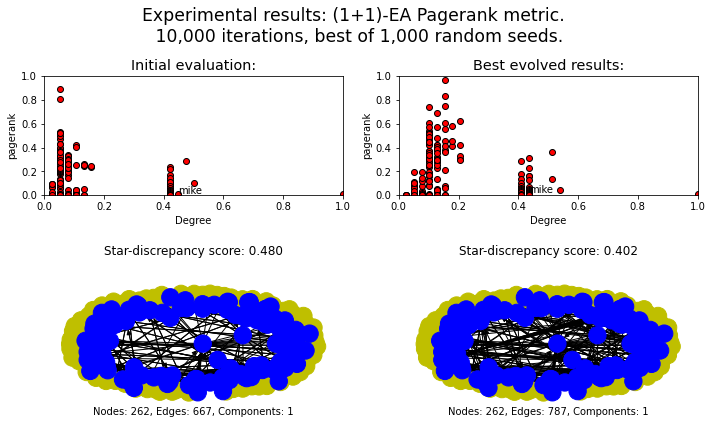

In [37]:
# set the best seed
scores_aux = scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True)]
np.random.seed(scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig5 = plot_all_results(connencted_adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig5

In [39]:
with PdfPages('Connected.pdf') as pdf:
    pdf.savefig(fig1)
    pdf.savefig(fig2)
    pdf.savefig(fig3)
    pdf.savefig(fig4)
    pdf.savefig(fig5)

scores.to_excel('results_02.xlsx', index=False)

## Experimental results:
### Connected graph and increased population

3.1 (1 + 20) betweeness centrality evaluation:

In [ ]:
seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.betweenness_centrality

scores_aux = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality, True)
scores = pd.concat([scores, scores_aux],axis=0)
scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True) & (scores['lam']==lam)].sort_values('score')

100%|██████████| 10/10 [02:16<00:00, 13.61s/it]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
8,8,11,0.256612,262,820,1,1,20,10000,betweenness_centrality,21.360333,True
2,2,5,0.258611,262,799,1,1,20,10000,betweenness_centrality,11.152424,True
3,3,5,0.268050,262,800,1,1,20,10000,betweenness_centrality,10.278159,True
5,5,6,0.268062,262,804,1,1,20,10000,betweenness_centrality,10.994009,True
6,6,8,0.269212,262,808,1,1,20,10000,betweenness_centrality,14.533581,True
0,0,15,0.270639,262,827,2,1,20,10000,betweenness_centrality,28.285283,True
7,7,7,0.276387,262,802,1,1,20,10000,betweenness_centrality,11.941652,True
4,4,5,0.277019,262,798,1,1,20,10000,betweenness_centrality,9.653213,True
1,1,6,0.279481,262,801,1,1,20,10000,betweenness_centrality,11.313503,True
9,9,4,0.321514,262,801,1,1,20,10000,betweenness_centrality,6.532510,True


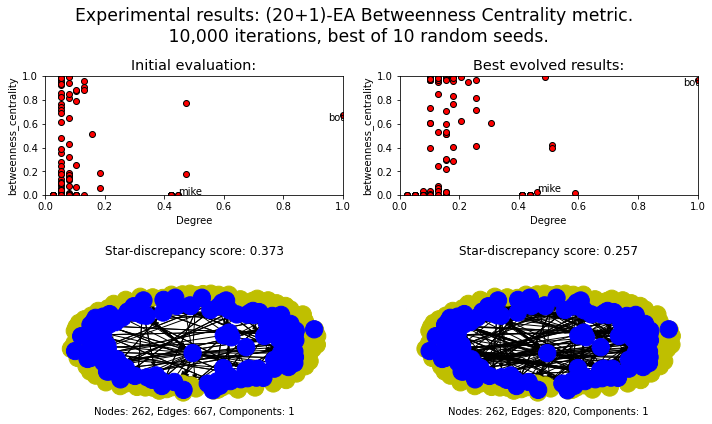

In [ ]:
# set the best seed
scores_aux = scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True) & (scores['lam']==lam)]
np.random.seed(scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig1 = plot_all_results(connencted_adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig1

3.2 (1 + 20) closeness centrality evaluation:

In [ ]:
seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.closeness_centrality

scores_aux = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality, True)
scores = pd.concat([scores, scores_aux],axis=0)
scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True) & (scores['lam']==lam)].sort_values('score')

100%|██████████| 10/10 [22:09<00:00, 132.91s/it]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
0,0,212,0.071455,262,1902,2,1,20,10000,closeness_centrality,248.663230,True
5,5,204,0.071960,262,1995,2,1,20,10000,closeness_centrality,249.640384,True
9,9,157,0.112803,262,1689,2,1,20,10000,closeness_centrality,181.976403,True
6,6,158,0.135751,262,1538,2,1,20,10000,closeness_centrality,156.785316,True
7,7,131,0.185243,262,1358,2,1,20,10000,closeness_centrality,129.351915,True
4,4,137,0.203549,262,1328,2,1,20,10000,closeness_centrality,130.932093,True
1,1,112,0.231642,262,1297,1,1,20,10000,closeness_centrality,107.630778,True
3,3,48,0.306290,262,1018,1,1,20,10000,closeness_centrality,49.047093,True
2,2,43,0.338449,262,933,1,1,20,10000,closeness_centrality,39.664706,True
8,8,37,0.353649,262,914,1,1,20,10000,closeness_centrality,35.342883,True


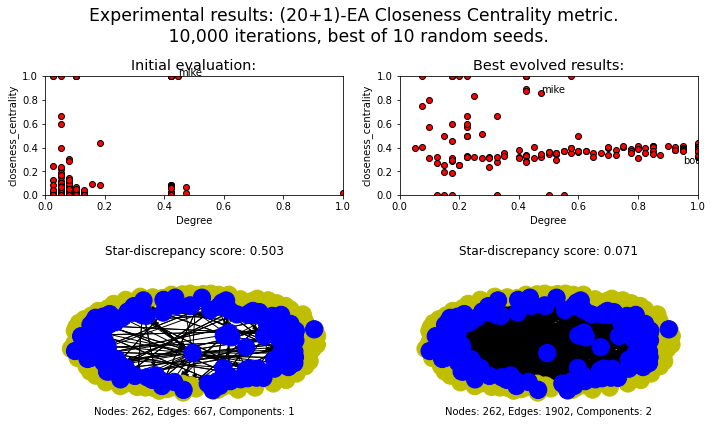

In [ ]:
# set the best seed
scores_aux = scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True) & (scores['lam']==lam)]
np.random.seed(scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig2 = plot_all_results(connencted_adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig2

3.3 (1 + 20) eigenvector centrality evaluation:

In [ ]:
seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.eigenvector_centrality

scores_aux = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality, True)
scores = pd.concat([scores, scores_aux],axis=0)
scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True) & (scores['lam']==lam)].sort_values('score')

100%|██████████| 10/10 [29:29<00:00, 176.93s/it]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
9,9,259,0.029460,262,2225,1,1,20,10000,eigenvector_centrality,199.375032,True
5,5,228,0.034298,262,2092,1,1,20,10000,eigenvector_centrality,183.876135,True
1,1,286,0.035032,262,2516,1,1,20,10000,eigenvector_centrality,214.726888,True
7,7,198,0.036395,262,1955,1,1,20,10000,eigenvector_centrality,155.469400,True
3,3,232,0.042613,262,2194,1,1,20,10000,eigenvector_centrality,177.303343,True
2,2,261,0.050112,262,2590,1,1,20,10000,eigenvector_centrality,198.080099,True
0,0,221,0.053260,262,2160,1,1,20,10000,eigenvector_centrality,176.144223,True
8,8,202,0.076281,262,1876,2,1,20,10000,eigenvector_centrality,164.729055,True
4,4,188,0.081338,262,1710,2,1,20,10000,eigenvector_centrality,159.222990,True
6,6,172,0.109846,262,1596,2,1,20,10000,eigenvector_centrality,140.341567,True


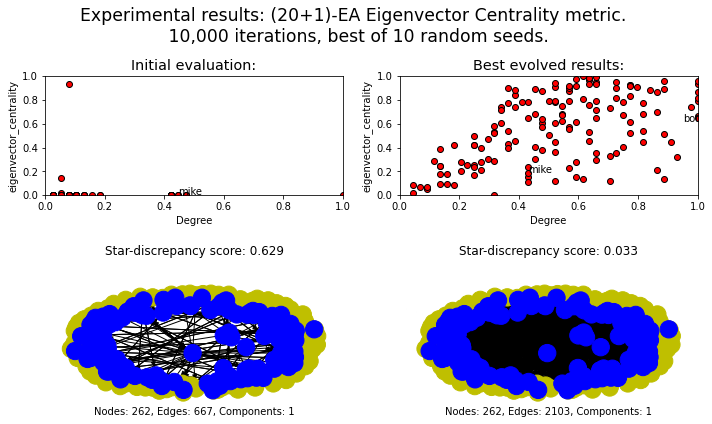

In [ ]:
# set the best seed
scores_aux = scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True) & (scores['lam']==lam)]
np.random.seed(scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig3 = plot_all_results(connencted_adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig3

3.4 (1 + 20) katz centrality evaluation:

In [ ]:
seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.katz_centrality

scores_aux = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality, True)
scores = pd.concat([scores, scores_aux],axis=0)
scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True) & (scores['lam']==lam)].sort_values('score')

 30%|███       | 3/10 [2:15:54<5:17:06, 2718.03s/it]


KeyboardInterrupt: 

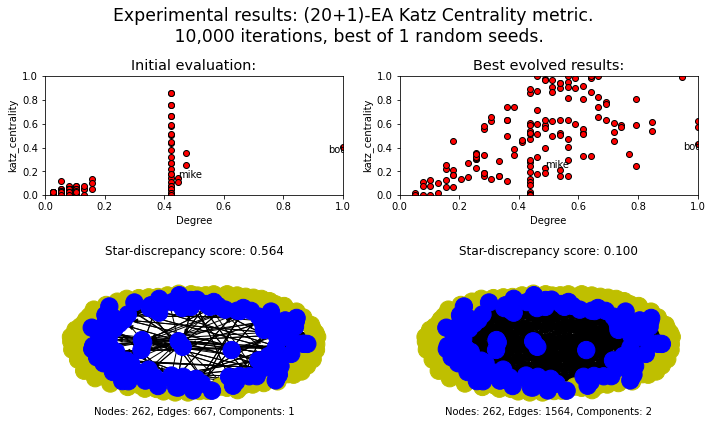

In [ ]:
# set the best seed
scores_aux = scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True) & (scores['lam']==lam)]
np.random.seed(scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig4 = plot_all_results(connencted_adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig4

3.5 (1 + 20) pagerank evaluation:

In [ ]:
seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.pagerank

scores_aux = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality, True)
scores = pd.concat([scores, scores_aux],axis=0)
scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True) & (scores['lam']==lam)].sort_values('score')

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


,seed,best_iter,score,nodes,edges,components,mu,lam,total_iter,centrality,time,connected
0,0,0,0.466799,262,667,1,1,20,10000,pagerank,1.146844,True


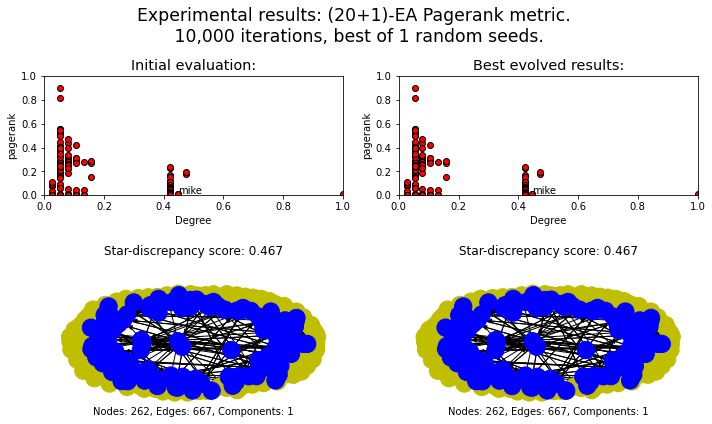

In [ ]:
# set the best seed
scores_aux = scores[(scores['centrality'] == str(centrality).split(' ')[1]) & (scores['connected']==True) & (scores['lam']==lam)]
np.random.seed(scores_aux[scores_aux['score'] == scores_aux['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score, ttime = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig5 = plot_all_results(connencted_adj_matrix, best, centrality, G, N, lam, mu, n_iter, seeds, pos)
fig5

In [ ]:
with PdfPages('Population.pdf') as pdf:
    pdf.savefig(fig1)
    pdf.savefig(fig2)
    pdf.savefig(fig3)
    pdf.savefig(fig4)
    pdf.savefig(fig5)

In [ ]:
scores.to_excel('results_02.xlsx', index=False)